<a id="1"></a>
# <p style="background-color:#000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Introduction</p>

> ### RetinaNet is one of the best one-stage object detection models that has proven to work well with dense and small scale objects. For this reason, it has become a popular object detection model to be used with aerial and satellite imagery. [read more...](https://developers.arcgis.com/python/guide/how-retinanet-works/)

> ### In this notebook, I will be training RetinaNet architecture from [fizyr](https://github.com/fizyr/keras-retinanet)

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Import Libraries</p>

In [ ]:
#!pip install progressbar2

In [ ]:
#!pip install contextlib2

In [ ]:
#!pip install shapely

In [1]:
#Clone Git Repository
#!git clone https://github.com/fizyr/keras-retinanet.git
%cd C:/Users/Gianlu/keras-retinanet/
#!python setup.py build_ext --inplace

C:\Users\Gianlu\keras-retinanet


In [2]:
%cd C:/Users/Gianlu/keras-retinanet/

C:\Users\Gianlu\keras-retinanet


**IMPORT LIBRARIES**

In [18]:
import pandas as pd
# show images inline
%matplotlib inline

import keras
import tensorflow as tf

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import ast

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet import models

# import libraries to download weights
import keras_resnet
import urllib.request

# libraries to transform data
import contextlib2
import io
import IPython
import json
import pathlib
import sys

# libraries for Confusion Matrix
from shapely.geometry import Polygon,Point
import shapely
import gc

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Download Pretrained Weights or connect to the ones from the last training</p>

Download original weights

In [ ]:
#!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet

#PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
#URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
#urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
#print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Weights from last training

In [107]:
PRETRAINED_MODEL = './snapshots/resnet50_csv_10.h5'

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Load Data </p>

In [4]:
def bbox_to_dict(row):
    dictionary= dict({'x_min': ast.literal_eval(row['bbox'])[0],
                  'y_min': ast.literal_eval(row['bbox'])[1],
                  'x_max': ast.literal_eval(row['bbox'])[2],
                  'y_max': ast.literal_eval(row['bbox'])[3]}
                  )
    return dictionary

def concat_name_row(row):
    concatenation=row['img_name']+str(row['Unnamed: 0'])
    return concatenation


In [5]:
df_train = pd.read_csv("D:/Pictures/dataset/new_images/train_augmented.csv")

df_train=df_train.loc[df_train["class"].astype(str) != '']
#df_train['img_name'] = df_train['img_name'].apply(eval)

df_train['image_path'] = "D:/Pictures/dataset/new_images/train/" + df_train['img_name'].astype(str) 
df_extrain=df_train.explode('img_name') # Single annotation per row
df_extrain['annotations']=df_extrain.apply(lambda row: bbox_to_dict(row), axis=1)
df_extrain['img_id']=df_extrain.apply(lambda row: concat_name_row(row), axis=1)
df_extrain.reset_index(inplace=True)
df_extrain.head()

,index,Unnamed: 0,img_name,class,bbox,bbox_count,object_count,stratify_group,fold,image_path,annotations,img_id
0,0,0,BloodImage_00322.jpg,Platelets,"['168', '374', '198', '406']",4.0,2.0,2_0,2.0,D:/Pictures/dataset/new_images/train/BloodImag...,"{'x_min': '168', 'y_min': '374', 'x_max': '198...",BloodImage_00322.jpg0
1,1,1,BloodImage_00322.jpg,Platelets,"['527', '244', '564', '282']",4.0,2.0,2_0,2.0,D:/Pictures/dataset/new_images/train/BloodImag...,"{'x_min': '527', 'y_min': '244', 'x_max': '564...",BloodImage_00322.jpg1
2,2,2,BloodImage_00322.jpg,Platelets,"['565', '383', '602', '421']",4.0,2.0,2_0,2.0,D:/Pictures/dataset/new_images/train/BloodImag...,"{'x_min': '565', 'y_min': '383', 'x_max': '602...",BloodImage_00322.jpg2
3,3,3,BloodImage_00322.jpg,WBC,"['307', '174', '528', '387']",4.0,2.0,2_0,2.0,D:/Pictures/dataset/new_images/train/BloodImag...,"{'x_min': '307', 'y_min': '174', 'x_max': '528...",BloodImage_00322.jpg3
4,4,4,BloodImage_00047.jpg,WBC,"['278', '147', '383', '259']",21.0,3.0,3_1,3.0,D:/Pictures/dataset/new_images/train/BloodImag...,"{'x_min': '278', 'y_min': '147', 'x_max': '383...",BloodImage_00047.jpg4


In [6]:
df_extrain_main=pd.DataFrame(pd.json_normalize(df_extrain['annotations']), columns=['x_min', 'y_min', 'x_max', 'y_max']).join(df_extrain)
df_extrain_main=df_extrain_main[df_extrain_main['class'].notna()]
df_extrain_main=df_extrain_main[['image_path','x_min', 'y_min', 'x_max', 'y_max','class','img_name','img_id']] 
df_extrain_main.head(10)

,image_path,x_min,y_min,x_max,y_max,class,img_name,img_id
0,D:/Pictures/dataset/new_images/train/BloodImag...,168,374,198,406,Platelets,BloodImage_00322.jpg,BloodImage_00322.jpg0
1,D:/Pictures/dataset/new_images/train/BloodImag...,527,244,564,282,Platelets,BloodImage_00322.jpg,BloodImage_00322.jpg1
2,D:/Pictures/dataset/new_images/train/BloodImag...,565,383,602,421,Platelets,BloodImage_00322.jpg,BloodImage_00322.jpg2
3,D:/Pictures/dataset/new_images/train/BloodImag...,307,174,528,387,WBC,BloodImage_00322.jpg,BloodImage_00322.jpg3
4,D:/Pictures/dataset/new_images/train/BloodImag...,278,147,383,259,WBC,BloodImage_00047.jpg,BloodImage_00047.jpg4
5,D:/Pictures/dataset/new_images/train/BloodImag...,207,214,240,242,Platelets,BloodImage_00047.jpg,BloodImage_00047.jpg5
6,D:/Pictures/dataset/new_images/train/BloodImag...,258,263,291,291,Platelets,BloodImage_00047.jpg,BloodImage_00047.jpg6
7,D:/Pictures/dataset/new_images/train/BloodImag...,12,277,40,311,Platelets,BloodImage_00047.jpg,BloodImage_00047.jpg7
8,D:/Pictures/dataset/new_images/train/BloodImag...,32,102,163,230,RBC,BloodImage_00047.jpg,BloodImage_00047.jpg8
9,D:/Pictures/dataset/new_images/train/BloodImag...,19,1,114,90,RBC,BloodImage_00047.jpg,BloodImage_00047.jpg9


<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Transfoming Data Format </p>

In [8]:
def create_tf_example(rowss,data_df):
    """Create a tf.Example entry for a given training image."""
    full_path = os.path.join(rowss.image_path)
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')

    height = image.size[1] # Image height
    width = image.size[0] # Image width
    #print(width,height)
    filename = f'{rowss.img_id}'.encode('utf8') # Unique id of the image.
    encoded_image_data = None # Encoded image bytes
    image_format = 'jpeg'.encode('utf8') # b'jpeg' or b'png'

    xmins = [] 
    xmaxs = [] 
    ymins = [] 
    ymaxs = [] 
    
    # Convert ---> [xmin,ymin,width,height] to [xmins,xmaxs,ymins,ymaxs]
    xmin = rowss['x_min']
    xmax = rowss['x_max']
    ymin = rowss['y_min']
    ymax = rowss['y_max']
    

    #main_data.append((rowss['image_path'],xmins,xmaxs,ymins,ymaxs))
    return rowss['image_path'],xmin,ymin,xmax,ymax

In [10]:
tf_example1=[]

from PIL import Image, ImageDraw
for index, row in df_extrain_main.iterrows():
            if index % 1000 == 0:
                print('Processed {0} images.'.format(index))
            image_path,xmins,ymins,xmaxs,ymaxs=create_tf_example(row,df_extrain_main)
            #print(image_path,xmins,xmaxs,ymins,ymaxs)
            df_extrain_main.loc[index,'image_path']=image_path
            df_extrain_main.loc[index,'x_min']=xmins
            df_extrain_main.loc[index,'y_min']=ymins
            df_extrain_main.loc[index,'x_max']=xmaxs
            df_extrain_main.loc[index,'y_max']=ymaxs


Processed 0 images.
Processed 1000 images.
Processed 4000 images.
Processed 5000 images.


In [11]:
df_extrain_main

,image_path,x_min,y_min,x_max,y_max,class,img_name,img_id
0,D:/Pictures/dataset/new_images/train/BloodImag...,168,374,198,406,Platelets,BloodImage_00322.jpg,BloodImage_00322.jpg0
1,D:/Pictures/dataset/new_images/train/BloodImag...,527,244,564,282,Platelets,BloodImage_00322.jpg,BloodImage_00322.jpg1
2,D:/Pictures/dataset/new_images/train/BloodImag...,565,383,602,421,Platelets,BloodImage_00322.jpg,BloodImage_00322.jpg2
3,D:/Pictures/dataset/new_images/train/BloodImag...,307,174,528,387,WBC,BloodImage_00322.jpg,BloodImage_00322.jpg3
4,D:/Pictures/dataset/new_images/train/BloodImag...,278,147,383,259,WBC,BloodImage_00047.jpg,BloodImage_00047.jpg4
...,...,...,...,...,...,...,...,...
5567,D:/Pictures/dataset/new_images/train/BloodImag...,74,324,192,422,RBC,BloodImage_00342_augmented_54_.jpg,BloodImage_00342_augmented_54_.jpg5567
5568,D:/Pictures/dataset/new_images/train/BloodImag...,203,1,302,72,RBC,BloodImage_00342_augmented_54_.jpg,BloodImage_00342_augmented_54_.jpg5568
5569,D:/Pictures/dataset/new_images/train/BloodImag...,492,413,578,480,RBC,BloodImage_00342_augmented_54_.jpg,BloodImage_00342_augmented_54_.jpg5569
5570,D:/Pictures/dataset/new_images/train/BloodImag...,322,256,440,366,RBC,BloodImage_00342_augmented_54_.jpg,BloodImage_00342_augmented_54_.jpg5570


<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Creating CSV for Training </p>

In [12]:
df_extrain_main['class'].unique()

array(['Platelets', 'WBC', 'RBC', 'FBC'], dtype=object)

In [13]:
classes=pd.DataFrame([{'class':'Platelets','label':0},{'class':'WBC','label':1},{'class':'RBC','label':2},{'class':'FBC','label':3}])
classes.to_csv("D:/Pictures/dataset/new_images/classes.csv",index=False,header=False)  # This CSV will be use in training

df_extrain_main['class']!=''
df_extrain_main[['image_path','x_min','y_min','x_max','y_max','class']].to_csv("D:/Pictures/dataset/new_images/annotation.csv",index=False,header=False)

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Training RetinaNet</p>

### Training this model 60 epochs for demo purpose.

In [ ]:
# !C:/Users/Gianlu/keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 1 --steps 200 --epochs 60 csv D:/Pictures/dataset/new_images/annotation.csv D:/Pictures/dataset/new_images/classes.csv

^C


In [108]:
TENSORBOARD_DIR='D:/Pictures/dataset/new_images/logs'

In [109]:
!C:/Users/Gianlu/keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 1 --steps 200 --epochs 10  --tensorboard-dir {TENSORBOARD_DIR} --weighted-average csv D:/Pictures/dataset/new_images/annotation.csv D:/Pictures/dataset/new_images/classes.csv

Creating model, this may take a second...

2022-10-10 23:50:08.112069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-10-10 23:50:08.112108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-10 23:50:12.036987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-10-10 23:50:12.038408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-10-10 23:50:12.040028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-10-10 23:50:12.041467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu


Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                      


D:\Programmi\Anaconda\envs\testhumanitas\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\Gianlu\keras-retinanet\keras_retinanet\bin\train.py:538: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return training_model.fit_generator(


In [ ]:
#SCRIPT TO EVALUATE MODEL
#!C:/Users/Gianlu/keras-retinanet/keras_retinanet/bin/evaluate.py --backbone=resnet50  csv D:/Pictures/dataset/new_images/annotation.csv D:/Pictures/dataset/new_images/classes.csv {PRETRAINED_MODEL}

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Load Trained Model</p>

In [110]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0]) 
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')  ## Use backbone as resnet50
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv("D:/Pictures/dataset/new_images/classes.csv",header=None).T.loc[0].to_dict()

snapshots\resnet50_csv_10.h5


<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Predicted vs Actual</p>

In [111]:
THRES_SCORE = 0.4  # Set Score Threshold Value

def class_to_color(class_id):
    colors = {'Platelets':(255,0,0),'WBC':(0,255,0),'RBC':(0,0,255),'FBC':(255,255,0)}
    return colors[class_id]

def df_plot_orinal(drawOG,img_path,df):
    df=df[df['image_path']==img_path]
    for i,r in df.iterrows():
        cv2.rectangle(drawOG, (int(r['x_min']), int(r['y_min'])), (int(r['x_max']), int(r['y_max'])), (255,0,0),2)
    

def img_inference(img_path):
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  drawOG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  df_plot_orinal(drawOG,img_path,df_extrain_main)
  # correct for image scale
  boxes /= scale
  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      #print(score)
      if score < THRES_SCORE:
          continue
      color = label_color(label)
      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}%".format(labels_to_names[label], score*100) #
      draw_caption(draw, b, caption)
    
  fig = plt.figure(figsize=(20, 20))
  ax1=fig.add_subplot(1, 2, 1)
  plt.imshow(draw)
  ax2=fig.add_subplot(1, 2, 2)
  plt.imshow(drawOG)

  ax1.title.set_text('Predicted')
  ax2.title.set_text('Actual')
  plt.show()

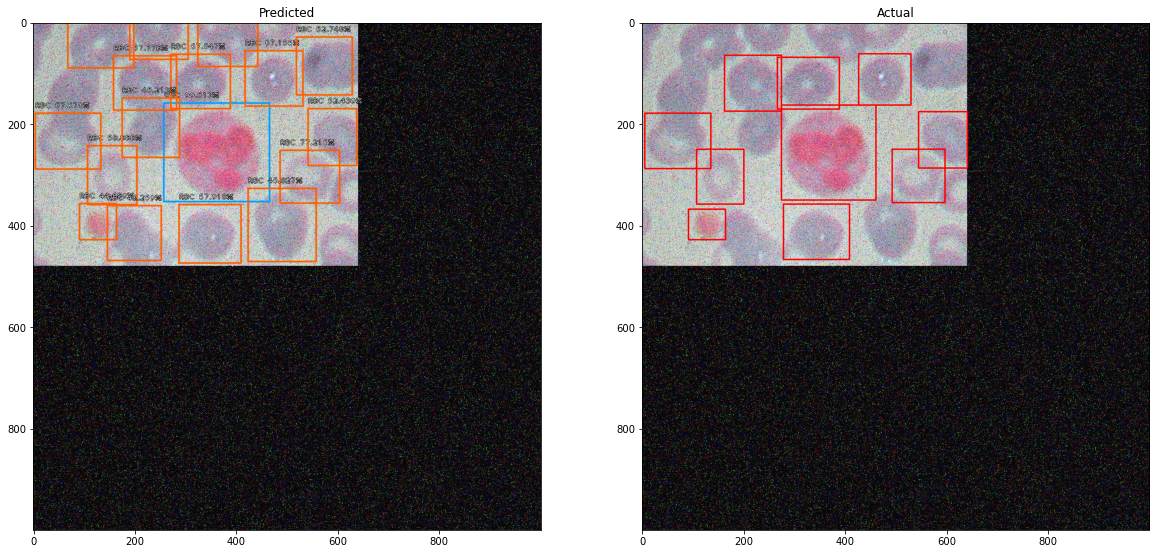

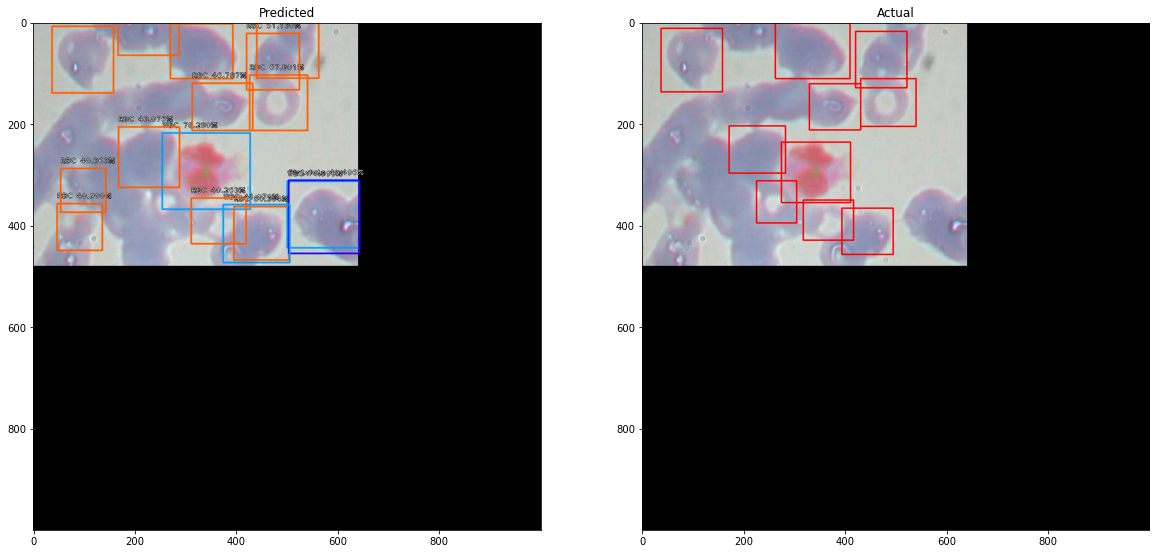

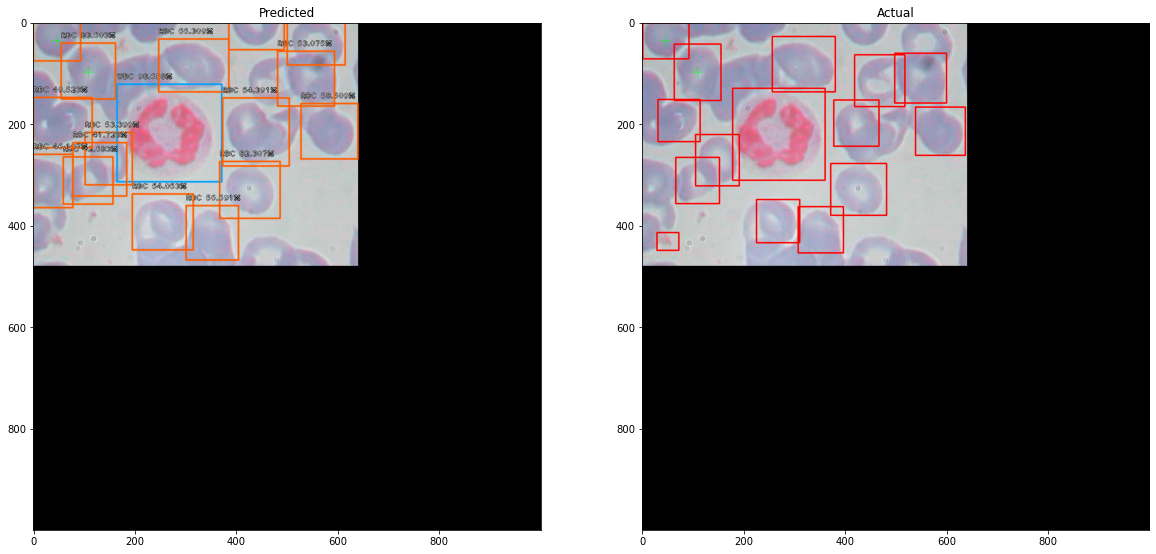

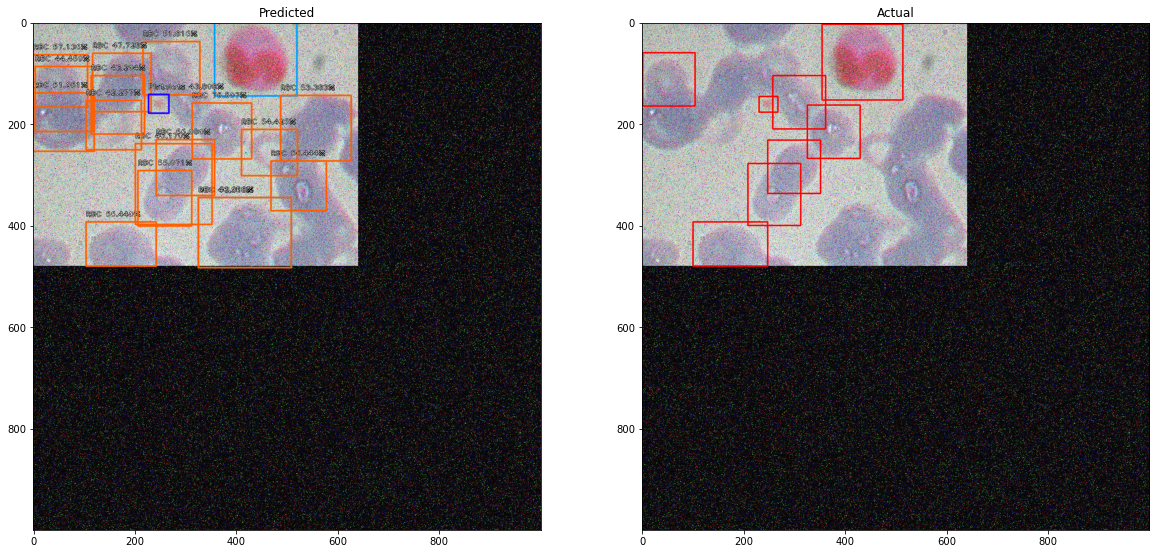

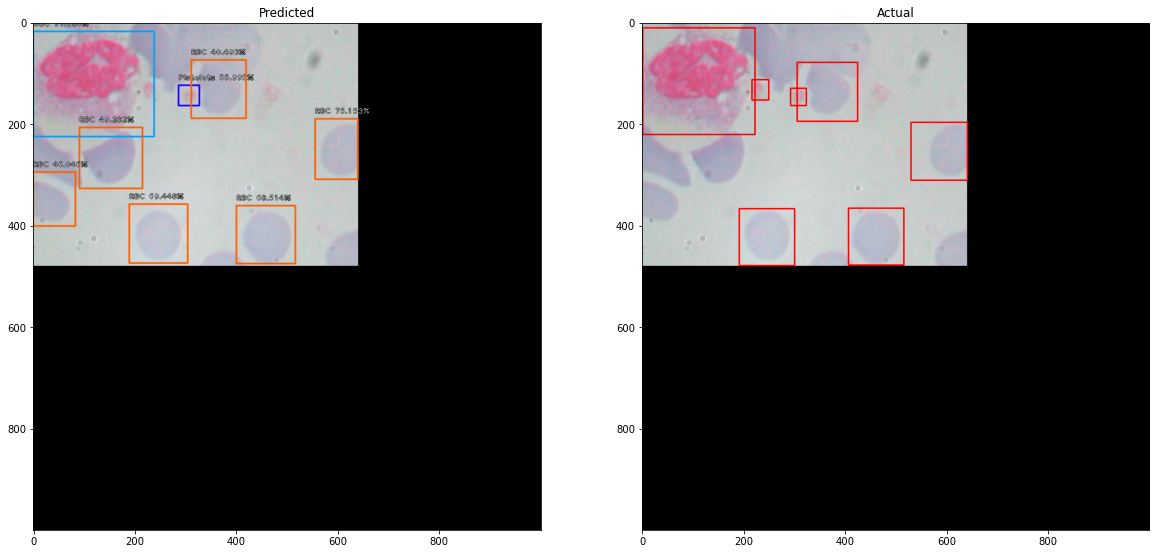

In [113]:
data=df_extrain_main.sample(n=5)  #Predict on Random 5 Image
for i,r in data.iterrows():
    img_inference(r['image_path'])

In [39]:
print(model.summary())

Model: "retinanet-bbox"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                  

**WIP CONFUSION MATRIX with RECALL, PRECISION**

In [ ]:
def img_inference_bbox_scores_labels(img_path):
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  drawOG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  return boxes , scores, labels


In [ ]:
data=df_extrain_main.sample(n=5)  #Predict on Random 5 Image
selection=data['img_name'].unique()
print(selection)
for i,r in data.iterrows():
    pred_boxes=img_inference_bbox_scores_labels(r['image_path'])

['BloodImage_00390.jpg' 'BloodImage_00032.jpg' 'BloodImage_00304.jpg'
 'BloodImage_00371.jpg' 'BloodImage_00002.jpg']


In [ ]:

def box_iou_calc(boxes1, boxes2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Array[N, 4])
        boxes2 (Array[M, 4])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    This implementation is taken from the above link and changed so that it only uses numpy..
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)


class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def process_batch(self, detections, labels: np.ndarray):
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                       for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[self.num_classes, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or ( all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0 ):
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))

In [ ]:
# predictions=np.concatenate((pred_boxes[0][0],pred_boxes[1].T), axis=1)
# predictions=np.concatenate((predictions,pred_boxes[2].T), axis=1)
# test_boxes=np.concatenate((pred_boxes[2].T,pred_boxes[0][0]), axis=1)
# print(test_boxes)

In [ ]:
predictions=np.concatenate((pred_boxes[0][0],pred_boxes[1].T), axis=1)
predictions=np.concatenate((predictions,pred_boxes[2].T), axis=1)

train_df_selection=df_extrain_main[['x_min', 'y_min','x_max','y_max','class','img_name']]# .to_numpy()

In [ ]:
# classes=pd.DataFrame([{'class':'Platelets','label':0},{'class':'WBC','label':1},{'class':'RBC','label':2},{'class':'FBC','label':3}])
# join_df=pd.merge(train_df_selection,classes,on='class')
# join_df=join_df[['x_min', 'y_min','x_max','y_max','label']]
# join_df=join_df.astype('int64')
# join_df=join_df.to_numpy()

In [ ]:
classes=pd.DataFrame([{'class':'Platelets','label':0},{'class':'WBC','label':1},{'class':'RBC','label':2},{'class':'FBC','label':3}])
selection=pd.DataFrame(selection,columns=['img_name'])
join_df=pd.merge(train_df_selection,classes,on='class')

join_df=pd.merge(join_df,selection,on='img_name')

join_df=join_df[['x_min', 'y_min','x_max','y_max','label']]
join_df=join_df.astype('int64')
join_df=join_df.to_numpy()

In [ ]:
conf_mat = ConfusionMatrix(num_classes = 4, CONF_THRESHOLD = 0.4, IOU_THRESHOLD = 0.5)

In [ ]:
print(conf_mat.print_matrix())

44.0 0.0 0.0 0.0 2.0
0.0 42.0 0.0 0.0 6.0
0.0 1.0 204.0 0.0 1.0
0.0 0.0 0.0 0.0 0.0
2.0 5.0 2.0 0.0 0.0
None


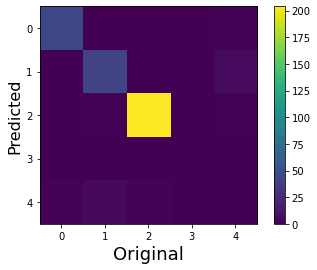

In [ ]:
plt.imshow(conf_mat.return_matrix())
plt.xlabel('Original', fontsize=18)
plt.ylabel('Predicted', fontsize=16)
plt.colorbar()
plt.show()

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;"> Reference </p>

> ### [Fizyr Keras Retinanet](https://github.com/fizyr/keras-retinanet)
> ### [Great Barrier Reef API Tutorial](https://www.kaggle.com/sohier/great-barrier-reef-api-tutorial)
> ### [Reef- Starter Torch FasterRCNN Infer](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-infer-lb-0-413)
